##Instalação de dependencias

In [1]:
!pip install tensorflow-gpu==2.1.0
!pip install tfa-nightly

## Importação bibliotecas

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

## Importação do modelo 2 classes

In [3]:
%%time
model_file = '/content/drive/My Drive/Colab Notebooks/Dermatologist_AI/ISIC_2018/xception_NV_MEL_precision_at_recall_0.90.best.weights.hdf5'

model = tf.keras.models.load_model(model_file)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Grad Cam Function

In [0]:
ORIGINAL = '/content/ISIC_0024315.jpg'

DIM = 299

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

#cv2_imshow(cv2.imread(ORIGINAL)) # Visualize image

In [0]:
def gradCAM(orig, intensity=0.5, res=250, layer='conv_7b', model=None):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer(layer)
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    print("Class Index: {}".format(np.argmax(model_out[0])))
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
   
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  print(heatmap.shape) 
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((heatmap.shape[1], heatmap.shape[2]))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))


## Show Gradcam 2 classes

{ \
  0: 'MEL',\
  1: 'NV' \
}


Class Index: 1
(1, 8, 8)


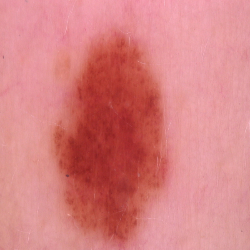

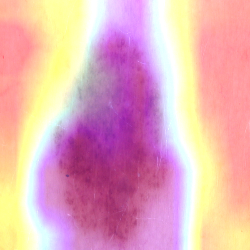

Class Index: 1
(1, 17, 17)


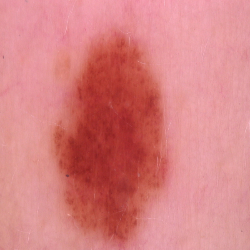

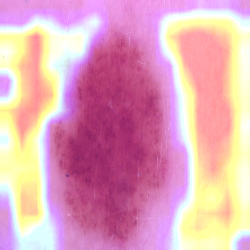

In [40]:
#file_2 = '/content/melanoma.jpg'
#file_2 = '/content/ISIC_0024315.jpg'
file_2 = '/content/ISIC_0024334.jpg'
#file_2 = '/content/melanoma2.jpeg'
#file_2 = '/content/melanoma_c.jpg'
gradCAM(file_2, model=model)
gradCAM(file_2, layer='conv2d_121', model=model)

### Importação Modelo 7 classes

In [9]:
%%time
img_shape = (299, 299, 3)
derm_ai_path = '/content/drive/My Drive/Colab Notebooks/Dermatologist_AI/ISIC_2018'
base_model_InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_InceptionResNetV2.output)
prediction_layer = tf.keras.layers.Dense(units = 7, activation = "softmax")(global_average_layer)
base_model_InceptionResNetV2 = tf.keras.models.Model(inputs = base_model_InceptionResNetV2.input, outputs = prediction_layer)
#optimizer
radam = tfa.optimizers.RectifiedAdam(
    lr=1e-2,
    total_steps=251,
    warmup_proportion=0.1,
    min_lr=1e-5)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
optm = ranger
base_model_InceptionResNetV2.compile(optimizer=optm, loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])
base_model_InceptionResNetV2.load_weights(os.path.join(derm_ai_path,'InceptionResNetV2_cat.weights.best.my.hdf5'))

base_model_InceptionResNetV2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

## Show Gradcam 7 classes

{\
  0: 'AKIEC',\
   1: 'BCC', \
   2: 'BKL',\
   3: 'DF', \
   4: 'MEL', \
   5: 'NV', \
   6: 'VASC'\
   }

Class Index: 4
(1, 8, 8)


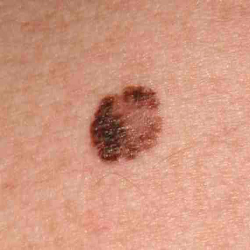

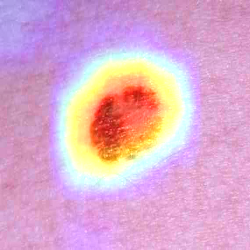

Class Index: 4
(1, 17, 17)


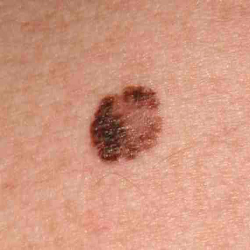

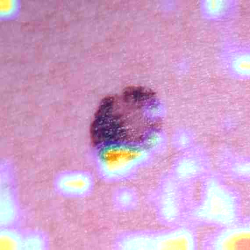

Class Index: 4
(1, 17, 17)


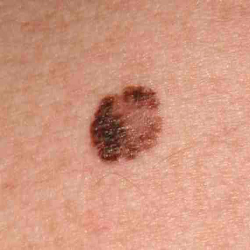

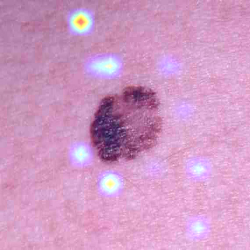

Class Index: 4
(1, 17, 17)


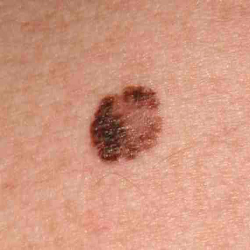

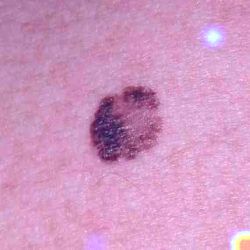

In [38]:
file_7 = '/content/melanoma.jpg'
#file_7 = '/content/ISIC_0024315.jpg'
#file_7 = '/content/ISIC_0024334.jpg'
#file_7 = '/content/melanoma2.jpeg'
#file_7 = '/content/melanoma_c.jpg'
gradCAM(file_7, model=base_model_InceptionResNetV2)
gradCAM(file_7, layer='conv2d_340', model=base_model_InceptionResNetV2)
gradCAM(file_7, layer='conv2d_344', model=base_model_InceptionResNetV2)
gradCAM(file_7, layer='conv2d_348', model=base_model_InceptionResNetV2)